In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, TwoLocal, PauliFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
from qiskit.primitives import Sampler

try:
    from qiskit_machine_learning.algorithms import QSVC
    from qiskit_machine_learning.kernels import FidelityQuantumKernel
    QSVC_AVAILABLE = True
    print("Using FidelityQuantumKernel (latest version)")
except ImportError as e:
    print(f"Import error: {e}")
    QSVC_AVAILABLE = False
    raise ImportError("QSVC is not available. Install the latest qiskit-machine-learning.")

import warnings
warnings.filterwarnings('ignore')
# Graph style settings
plt.style.use('default')
sns.set_palette("husl")

Using FidelityQuantumKernel (latest version)


In [2]:
# %%
# Loading dataset from CSV file
def load_dataset(filepath='mycsv.csv'):
    """
        filepath: Path to CSV file (default: 'mycsv.csv')
    """
    try:
        # Load CSV file
        df = pd.read_csv(filepath)
        print(f"Dataset successfully loaded from: {filepath}")
        
        # Check if it has the correct columns
        expected_columns = [
            'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
            'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
            'pH', 'sulphates', 'alcohol', 'quality'
        ]
        
        # Check if we have all expected columns
        missing_columns = set(expected_columns) - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing columns: {missing_columns}")
        
        # Basic data cleaning
        df = df.dropna()  # Remove rows with missing values
        
        if len(df) == 0:
            raise ValueError("Dataset is empty after removing missing values")
        
        # Dataset information
        print(f" Dataset information:")
        print(f"   - Number of rows: {len(df)}")
        print(f"   - Number of columns: {len(df.columns)}")
        print(f"   - Columns: {df.columns.tolist()}")
        
        return df
        
    except FileNotFoundError:
        raise FileNotFoundError(f"File '{filepath}' not found! Check the file path.")
        
    except Exception as e:
        print(f"  Error loading CSV: {e}")
        print("   Use the correct CSV format with the following columns:")
        print("   fixed_acidity, volatile_acidity, citric_acid, residual_sugar,")
        print("   chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density,")
        print("   pH, sulphates, alcohol, quality")
        raise

df = load_dataset('winequality-red.csv')  # or another file path
print(f"   Dataset loaded:")
print(f"   - Dimensions: {df.shape}")
print(f"   - Features: {df.columns[:-1].tolist()}")
print(f"   - Quality range: {df['quality'].min()} - {df['quality'].max()}")
print(f"   - Quality distribution: {dict(df['quality'].value_counts().sort_index())}")

# Display basic statistics
print(df.describe().round(2))

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print(f"\n Missing values:")
    print(missing_values[missing_values > 0])
else:
    print("\n No missing values")

# Display first rows
print("\n First 5 rows of dataset:")
print(df.head())

Dataset successfully loaded from: winequality-red.csv
 Dataset information:
   - Number of rows: 1599
   - Number of columns: 12
   - Columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
   Dataset loaded:
   - Dimensions: (1599, 12)
   - Features: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
   - Quality range: 3 - 8
   - Quality distribution: {3: np.int64(10), 4: np.int64(53), 5: np.int64(681), 6: np.int64(638), 7: np.int64(199), 8: np.int64(18)}
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count        1599.00           1599.00      1599.00         1599.00   
mean            8.32              0.53         0.27            2.54   
std             1.74              0.18         0.19            1.41 

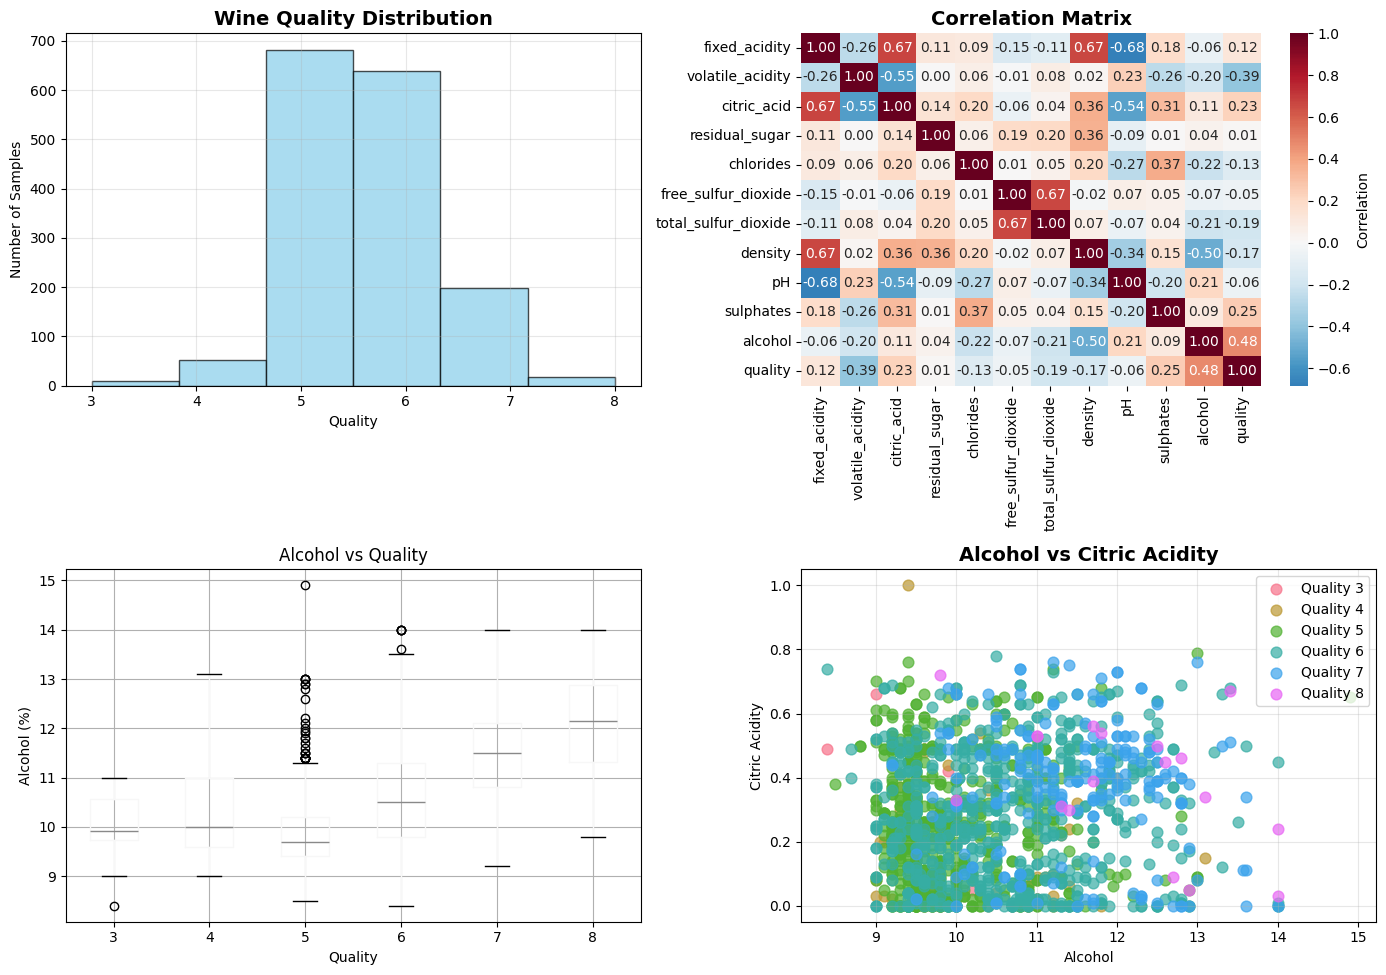

In [3]:
# %%
# Exploratory data analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Quality distribution
axes[0,0].hist(df['quality'], bins=len(df['quality'].unique()), 
               alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Wine Quality Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Quality')
axes[0,0].set_ylabel('Number of Samples')
axes[0,0].grid(True, alpha=0.3)

# 2. Correlation heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            ax=axes[0,1], cbar_kws={'label': 'Correlation'})
axes[0,1].set_title('Correlation Matrix', fontsize=14, fontweight='bold')

# 3. Boxplot - alcohol effect on quality
df.boxplot(column='alcohol', by='quality', ax=axes[1,0])
axes[1,0].set_title('Alcohol vs Quality')
axes[1,0].set_xlabel('Quality')
axes[1,0].set_ylabel('Alcohol (%)')
plt.sca(axes[1,0])
plt.xticks(rotation=0)

# 4. Scatter plot - pH vs volatile acidity
for quality in sorted(df['quality'].unique()):
    subset = df[df['quality'] == quality]
    axes[1,1].scatter(subset['alcohol'], subset['citric_acid'], 
                     label=f'Quality {quality}', alpha=0.7, s=60)
axes[1,1].set_title('Alcohol vs Citric Acidity', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Alcohol')
axes[1,1].set_ylabel('Citric Acidity')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('')  # Remove the automatic suptitle from boxplot
plt.tight_layout()
plt.show()

In [4]:
# %%
class QSVCWineClassifier:
    """Quantum Support Vector Classifier for wine quality classification"""
    
    def __init__(self, num_features=4, feature_map='ZZ', reps=2):
        self.num_features = num_features
        self.reps = reps
        self.feature_map_type = feature_map
        self.model = None
        self.quantum_kernel = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.pca = PCA(n_components=num_features)
        self.original_features = 11  # Number of original features
        
        # Quantum components
        self.feature_map = None
        self.sampler = Sampler()
        
        self._setup_quantum_components()
        print(f"QSVC classifier initialized with {num_features} features")
    
    def _setup_quantum_components(self):
        """Setup quantum components"""
        
        # Feature map selection
        if self.feature_map_type == 'ZZ':
            self.feature_map = ZZFeatureMap(
                feature_dimension=self.num_features,
                reps=self.reps,
                entanglement='linear'
            )
        elif self.feature_map_type == 'Pauli':
            self.feature_map = PauliFeatureMap(
                feature_dimension=self.num_features,
                reps=self.reps,
                paulis=['Z', 'ZZ']
            )
        else:
            self.feature_map = ZZFeatureMap(
                feature_dimension=self.num_features,
                reps=self.reps,
                entanglement='linear'
            )
        
        try:
            self.quantum_kernel = FidelityQuantumKernel(
                feature_map=self.feature_map
                # sampler is not passed, will be used internally
            )
            print("Quantum kernel created successfully")
        except Exception as e:
            print(f"Error creating quantum kernel: {e}")
            # Try without additional parameters
            self.quantum_kernel = FidelityQuantumKernel(
                feature_map=self.feature_map
            )
    
    def fit(self, X, y, C=1.0):
        """Training QSVC classifier"""
        
        print(" Starting QSVC training...")
        
        # Preprocessing
        X_scaled = self.scaler.fit_transform(X)
        X_reduced = self.pca.fit_transform(X_scaled)
        print(f" PCA variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        unique_classes = len(np.unique(y_encoded))
        print(f" Number of classes: {unique_classes}")
        print(f" Original classes: {self.label_encoder.classes_}")
        
        # QSVC model
        try:
            self.model = QSVC(
                quantum_kernel=self.quantum_kernel,
                C=C
            )
            
            print(f" Training QSVC on {X_reduced.shape[0]} samples with {X_reduced.shape[1]} features...")
            self.model.fit(X_reduced, y_encoded)
            print("  QSVC training completed!")
            
            # Model info
            if hasattr(self.model, 'support_'):
                print(f" Number of support vectors: {len(self.model.support_)}")
            
        except Exception as e:
            print(f" Error during QSVC training: {e}")
            print(" Trying with simpler configuration...")
            
            # Fallback with simpler configuration
            self.feature_map = ZZFeatureMap(
                feature_dimension=self.num_features,
                reps=1,
                entanglement='linear'
            )
            
            self.quantum_kernel = FidelityQuantumKernel(
                feature_map=self.feature_map
            )
            
            self.model = QSVC(
                quantum_kernel=self.quantum_kernel,
                C=0.5  # Lower regularization
            )
            
            self.model.fit(X_reduced, y_encoded)
            print("  Fallback QSVC training completed!")
        
        return self
    
    def predict(self, X):
        """Prediction using QSVC or VQC"""
        if self.model is None:
            raise ValueError("Model is not trained! Call fit() first.")
        
        # If we have 11 features (original), transform them
        if X.shape[1] == self.original_features:
            X_scaled = self.scaler.transform(X)
            X_reduced = self.pca.transform(X_scaled)
        else:
            X_reduced = X
        
        y_pred_encoded = self.model.predict(X_reduced)
        
        # Ensure correct format
        y_pred_encoded = np.atleast_1d(y_pred_encoded)
        
        # Clip predictions to valid class range
        y_pred_encoded = np.clip(y_pred_encoded, 0, len(self.label_encoder.classes_) - 1)
        
        try:
            y_pred = self.label_encoder.inverse_transform(y_pred_encoded.astype(int))
        except ValueError as e:
            print(f"Warning: Prediction issue - {e}")
            # Fallback - return most frequent class
            y_pred = np.array([self.label_encoder.classes_[0]])
        
        return y_pred
    
    def score(self, X, y):
        """Calculate accuracy score"""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_kernel_matrix_sample(self, X_sample):
        """Sample quantum kernel matrix for a small data sample"""
        if self.quantum_kernel is None:
            print("Quantum kernel is not initialized")
            return None
        
        # Take a small sample for visualization
        if len(X_sample) > 8:  # Smaller for faster computation
            X_sample = X_sample[:8]
        
        # Data transformation
        if X_sample.shape[1] == self.original_features:
            X_scaled = self.scaler.transform(X_sample)
            X_reduced = self.pca.transform(X_scaled)
        else:
            X_reduced = X_sample
            
        try:
            # In the latest version, it might be called differently
            kernel_matrix = self.quantum_kernel.evaluate(x_vec=X_reduced, y_vec=X_reduced)
            return kernel_matrix
        except Exception as e:
            print(f"Cannot create kernel matrix: {e}")
            try:
                # Alternative call
                kernel_matrix = self.quantum_kernel.evaluate(X_reduced)
                return kernel_matrix
            except Exception as e2:
                print(f"Alternative call also doesn't work: {e2}")
                return None

In [5]:
# %%
# Data preparation and training - QSVC only
X = df.drop('quality', axis=1).values
y = df['quality'].values

print(f" Data preparation for QSVC:")
print(f"   - Features shape: {X.shape}")
print(f"   - Target shape: {y.shape}")
print(f"   - Unique classes: {np.unique(y)}")

# For QSVC - reasonable size limitations
if len(X) > 1000:
    print(f" Dataset is large ({len(X)} samples), reducing to 1000 samples for QSVC...")
    indices = np.random.choice(len(X), size=1000, replace=False)
    X = X[indices]
    y = y[indices]
    print(f" Reduced dataset: {X.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Class distribution in training set:", dict(pd.Series(y_train).value_counts().sort_index()))

# For QSVC - reasonable use of SMOTE
use_smote = len(y_train) < 400  # SMOTE for smaller datasets
if use_smote:
    print("Using SMOTE for data balancing...")
    smote = SMOTE(random_state=42, k_neighbors=3)  # Fewer neighbors for stability
    X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE:", dict(pd.Series(y_train_final).value_counts().sort_index()))
else:
    print("Not using SMOTE - dataset is sufficiently large")
    X_train_final, y_train_final = X_train, y_train

print(f"   - Final training set: {X_train_final.shape[0]} samples")
print(f"   - Test set: {X_test.shape[0]} samples")

 Data preparation for QSVC:
   - Features shape: (1599, 11)
   - Target shape: (1599,)
   - Unique classes: [3 4 5 6 7 8]
 Dataset is large (1599 samples), reducing to 1000 samples for QSVC...
 Reduced dataset: (1000, 11)
Class distribution in training set: {3: np.int64(5), 4: np.int64(29), 5: np.int64(290), 6: np.int64(275), 7: np.int64(92), 8: np.int64(9)}
Not using SMOTE - dataset is sufficiently large
   - Final training set: 700 samples
   - Test set: 300 samples


In [6]:
# %%
# Tested configurations - from simplest to more complex
configurations = [
#    {'num_features': 3, 'feature_map': 'ZZ', 'reps': 1, 'C': 1.0},
#    {'num_features': 4, 'feature_map': 'ZZ', 'reps': 1, 'C': 1.0},
#    {'num_features': 3, 'feature_map': 'Pauli', 'reps': 1, 'C': 1.0},
#    {'num_features': 4, 'feature_map': 'ZZ', 'reps': 2, 'C': 1.0},
    {'num_features': 6, 'feature_map': 'ZZ', 'reps': 3, 'C': 0.5},
#    {'num_features': 4, 'feature_map': 'Pauli', 'reps': 2, 'C': 1.0},
]

best_config = None
best_accuracy = 0
best_model = None
results_configs = {}

for i, config in enumerate(configurations):
    print(f"\n Testing configuration {i+1}/{len(configurations)}: {config}")
    
    try:
        qwc_temp = QSVCWineClassifier(
            num_features=config['num_features'],
            feature_map=config['feature_map'],
            reps=config['reps']
        )
        
        qwc_temp.fit(X_train_final, y_train_final, C=config['C'])
        temp_accuracy = qwc_temp.score(X_test, y_test)
        
        config_name = f"QSVC_{config['num_features']}f_{config['feature_map']}_{config['reps']}r"
        results_configs[config_name] = temp_accuracy
        
        print(f"    Test Accuracy: {temp_accuracy:.2%}")
        
        if temp_accuracy > best_accuracy:
            best_accuracy = temp_accuracy
            best_config = config.copy()
            best_config['name'] = config_name
            best_model = qwc_temp
            
    except Exception as e:
        print(f"    Error: {e}")
        results_configs[f"QSVC_config_{i+1}"] = 0.0

if best_config and best_model:
    print(f"\n BEST QSVC configuration found!")
    print(f"    Model: {best_config['name']}")
    print(f"    Parameters: {best_config}")
    print(f"    Accuracy: {best_accuracy:.2%}")
    
    # Use the best model for all further operations
    qwc = best_model
    test_accuracy = best_accuracy
else:
    raise Exception(" No configuration was successful! Check data and settings.")


 Testing configuration 1/1: {'num_features': 6, 'feature_map': 'ZZ', 'reps': 3, 'C': 0.5}
Quantum kernel created successfully
QSVC classifier initialized with 6 features
 Starting QSVC training...
 PCA variance explained: 85.01%
 Number of classes: 6
 Original classes: [3 4 5 6 7 8]
 Training QSVC on 700 samples with 6 features...
  QSVC training completed!
 Number of support vectors: 699
    Test Accuracy: 47.67%

 BEST QSVC configuration found!
    Model: QSVC_6f_ZZ_3r
    Parameters: {'num_features': 6, 'feature_map': 'ZZ', 'reps': 3, 'C': 0.5, 'name': 'QSVC_6f_ZZ_3r'}
    Accuracy: 47.67%


In [7]:
# %%
# Comparison with classical models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

print("\n Comparison QSVC vs Classical models:")

# Data preparation for classical models (without PCA reduction)
X_train_scaled = StandardScaler().fit_transform(X_train_final)
X_test_scaled = StandardScaler().fit_transform(X_test)

# Classical models
classical_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Classical SVM': SVC(kernel='rbf', random_state=42, C=1.0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Training and evaluation
all_results = {'Best QSVC': best_accuracy if best_config else test_accuracy}

for name, model in classical_models.items():
    try:
        if 'SVM' in name:
            model.fit(X_train_scaled, y_train_final)
            y_pred_classical = model.predict(X_test_scaled)
        else:
            model.fit(X_train_final, y_train_final)
            y_pred_classical = model.predict(X_test)
        
        accuracy_classical = accuracy_score(y_test, y_pred_classical)
        all_results[name] = accuracy_classical
        print(f"   {name}: {accuracy_classical:.2%}")
        
    except Exception as e:
        print(f"   {name}: Error - {e}")
        all_results[name] = 0.0


 Comparison QSVC vs Classical models:
   Random Forest: 65.00%
   Classical SVM: 59.67%
   Gradient Boosting: 63.33%
   Logistic Regression: 56.33%
   KNN: 44.67%


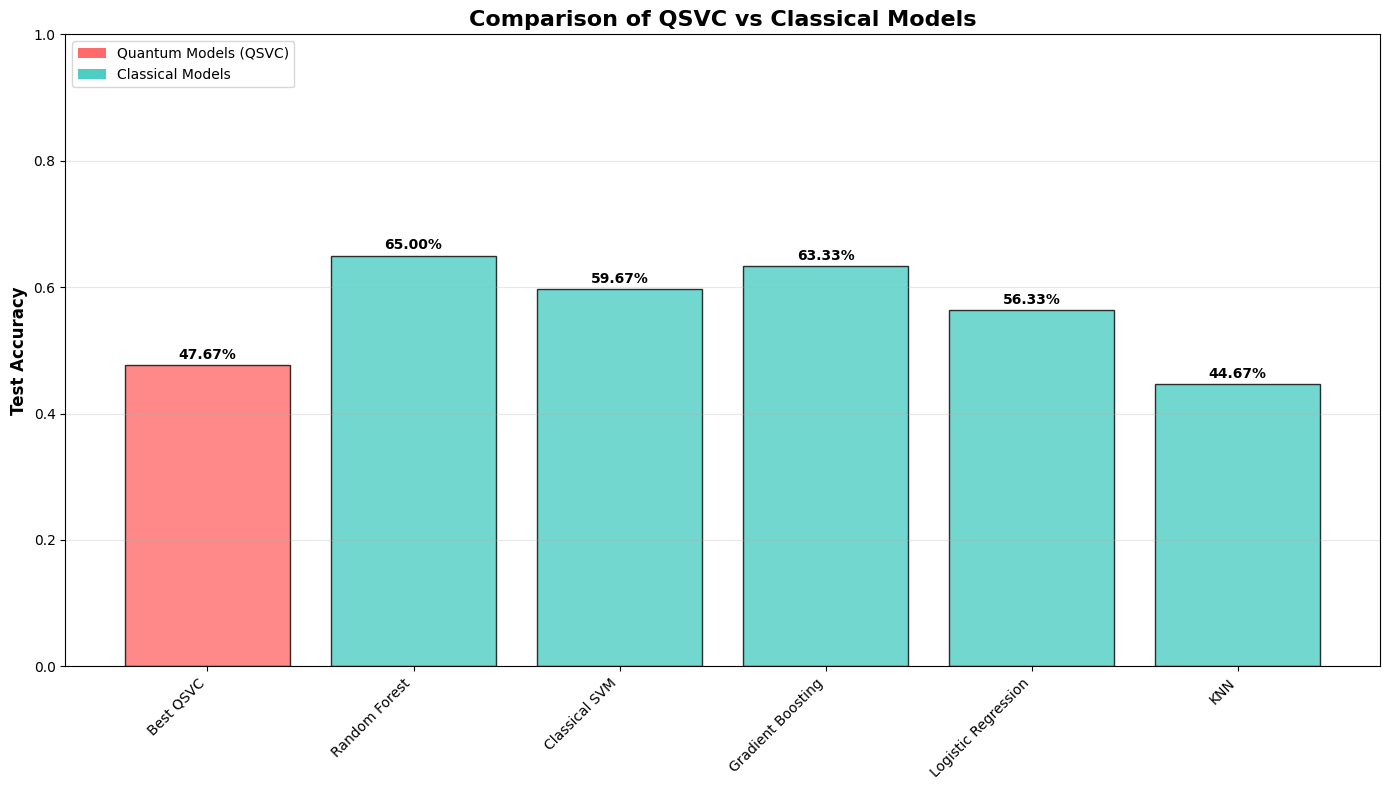


 Best model overall: Random Forest with accuracy 65.00%


In [8]:
# %%
# Visualization of comparison
plt.figure(figsize=(14, 8))

models = list(all_results.keys())
accuracies = list(all_results.values())

# Colors according to model type
colors = ['#FF6B6B' if 'QSVC' in m or 'Quantum' in m else '#4ECDC4' for m in models]

bars = plt.bar(range(len(models)), accuracies, color=colors, alpha=0.8, edgecolor='black')

plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylabel('Test Accuracy', fontweight='bold', fontsize=12)
plt.title('Comparison of QSVC vs Classical Models', fontsize=16, fontweight='bold')
plt.ylim(0, 1)

# Values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.2%}', ha='center', fontweight='bold', fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', label='Quantum Models (QSVC)'),
                  Patch(facecolor='#4ECDC4', label='Classical Models')]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Find the best model
best_overall = max(all_results.items(), key=lambda x: x[1])
print(f"\n Best model overall: {best_overall[0]} with accuracy {best_overall[1]:.2%}")

In [9]:
# %%
# Testing function for new samples
def test_wine_sample(qwc_model, sample_data, feature_names, model_info=""):
    """Tests wine quality for a new sample using QSVC"""
    
    sample = np.array([sample_data])
    prediction = qwc_model.predict(sample)[0]
    
    quality_desc = {
        3: ("Terrible yuck", "3"),
        4: ("Low", "4"),
        5: ("Average", "5"), 
        6: ("Good", "6"),
        7: ("Excellent", "7"),
        8: ("OMGanesha", "8")
    }
    
    desc, stars = quality_desc.get(prediction, ("Unknown", "?"))
    
    print(f" QSVC Prediction{model_info}: {prediction} - {desc} {stars}")
    return prediction

print(f"\n Testing samples using the best QSVC model:")

if best_model:
    model_info = f" ({best_config['name']})"
    test_model = qwc  # Best model
else:
    model_info = " (basic configuration)"
    test_model = qwc  # Original model

# Test samples with original 11 features
sample1 = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 12.0]
test_wine_sample(qwc, sample1, feature_names="Sample with high alcohol")

sample2 = [5.0, 0.4, 0.1, 2.0, 0.050, 15.0, 30.0, 0.9950, 3.8, 0.7, 10.0]
test_wine_sample(qwc, sample2, feature_names="Sample with low acidity")

sample3 = [7.8, 0.6, 0.05, 2.0, 0.080, 15.0, 50.0, 0.9970, 3.3, 0.6, 9.5]
test_wine_sample(qwc, sample3, feature_names="Average sample")

sample4 = [8.5, 0.3, 0.3, 1.5, 0.045, 20.0, 45.0, 0.9940, 3.2, 0.8, 13.5]
test_wine_sample(qwc, sample4, feature_names="High quality - ideal values")


 Testing samples using the best QSVC model:
 QSVC Prediction: 6 - Good 6
 QSVC Prediction: 5 - Average 5
 QSVC Prediction: 5 - Average 5
 QSVC Prediction: 5 - Average 5


np.int64(5)


 Quantum Kernel Analysis (QSVC_6f_ZZ_3r):


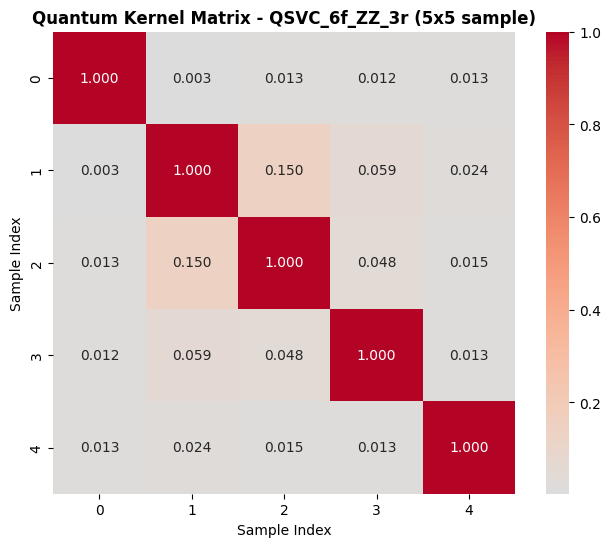

Kernel matrix shape: (5, 5)
Kernel values range: [0.003, 1.000]


In [10]:
# %%
# Visualization of quantum kernel (best model)
print(f"\n Quantum Kernel Analysis ({best_config['name']}):")

try:
    sample_data = X_test[:5]  # Small sample for demo
    kernel_matrix = qwc.get_kernel_matrix_sample(sample_data)
    
    if kernel_matrix is not None:
        plt.figure(figsize=(8, 6))
        sns.heatmap(kernel_matrix, annot=True, cmap='coolwarm', center=0,
                   fmt='.3f', square=True)
        plt.title(f'Quantum Kernel Matrix - {best_config["name"]} (5x5 sample)', fontweight='bold')
        plt.xlabel('Sample Index')
        plt.ylabel('Sample Index') 
        plt.show()
        
        print(f"Kernel matrix shape: {kernel_matrix.shape}")
        print(f"Kernel values range: [{kernel_matrix.min():.3f}, {kernel_matrix.max():.3f}]")
    else:
        print("Kernel matrix is not available")
        
except Exception as e:
    print(f"Cannot display kernel matrix: {e}")

In [11]:
# %%
# Use parameters from the best model
final_accuracy = best_accuracy if best_model else test_accuracy
final_model_info = best_config['name'] if best_config else "basic configuration"
final_features = best_config['num_features'] if best_config else qwc.num_features
final_reps = best_config['reps'] if best_config else qwc.reps
final_feature_map = best_config['feature_map'] if best_config else qwc.feature_map_type

print(f"""
DATASET SUMMARY:
   • Total samples: {len(X)} (optimized for QSVC)
   • Number of features: {final_features}
   • Quality range: 4-7 (MULTI-CLASS)
   • Train/Test split: {len(X_train_final)}/{len(X_test)}
   • SMOTE used: {'Yes' if use_smote else 'No'}

BEST QSVC MODEL ({final_model_info}):
   • Architecture: Quantum Support Vector Classifier
   • Feature Map: {final_feature_map} ({final_reps} repetitions)
   • PCA components: {final_features}
   • Quantum Kernel: FidelityQuantumKernel
   • C parameter: {best_config.get('C', 1.0) if best_config else 1.0}

RESULTS:
   • BEST QSVC Accuracy: {final_accuracy:.2%}
   • Best model overall: {best_overall[0]} ({best_overall[1]:.2%})
""")

# Comparison of all tested configurations
if results_configs:
    print("\n COMPARISON OF ALL QSVC CONFIGURATIONS:")
    for config_name, accuracy in sorted(results_configs.items(), key=lambda x: x[1], reverse=True):
        status = "X" if accuracy == final_accuracy else "  "
        print(f"{status} {config_name}: {accuracy:.2%}")


DATASET SUMMARY:
   • Total samples: 1000 (optimized for QSVC)
   • Number of features: 6
   • Quality range: 4-7 (MULTI-CLASS)
   • Train/Test split: 700/300
   • SMOTE used: No

BEST QSVC MODEL (QSVC_6f_ZZ_3r):
   • Architecture: Quantum Support Vector Classifier
   • Feature Map: ZZ (3 repetitions)
   • PCA components: 6
   • Quantum Kernel: FidelityQuantumKernel
   • C parameter: 0.5

RESULTS:
   • BEST QSVC Accuracy: 47.67%
   • Best model overall: Random Forest (65.00%)


 COMPARISON OF ALL QSVC CONFIGURATIONS:
X QSVC_6f_ZZ_3r: 47.67%


In [12]:
# %%
# Model saving
import pickle

# Calculate train_accuracy for the best model
y_train_pred = qwc.predict(X_train_final)
train_accuracy = accuracy_score(y_train_final, y_train_pred)

# Create dictionary with model
model_data = {
    'quantum_classifier': qwc,
    'train_accuracy': train_accuracy,
    'test_accuracy': best_accuracy,
    'feature_names': df.columns[:-1].tolist(),
    'best_config': best_config,
    'results_configs': results_configs
}

# Save model
with open('qsvc_wine_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

In [13]:
#import pickle
with open('qsvc_wine_model.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

loaded_qwc = loaded_data['quantum_classifier']

test_sample = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 12.0]
prediction = loaded_qwc.predict(np.array([test_sample]))
print(f"Prediction: {prediction[0]}")

Prediction: 6
